# Tutorlal for extracting SEDs from Galacticus output.

Note that to extract an SED Galacticus must have been run with the option to output an array of top hat filters at user-specified wavelengths.

In [1]:
import sys
import numpy as np
from galacticus.plotting.utils import *
from galacticus.io import GalacticusHDF5
from galacticus.spectralEnergyDistributions import GalacticusSED
%matplotlib inline

In [2]:
# Load Galacticus HDF5 file and initialize GalacticusHDF5 class to load Galacticus data
ifile = "/Users/amerson/Data/Galacticus_Out/v0.9.4/wfirstSED_singleTree_lightcone/galacticus.hdf5"
#ifile = "../galacticus/data/exampleRuns/galacticus.snapshotExample.hdf5"
#ifile = "../galacticus/data/exampleRuns/galacticus.lightconeExample.hdf5"
GH5 = GalacticusHDF5(ifile,'r')

In [3]:
# Print redshift outputs  
print("Redshift Outputs:")
for i,z in enumerate(GH5.outputs):
    print(GH5.outputs.name[i]+": z = "+str(GH5.outputs.z[i]))

Redshift Outputs:
Output1: z = 2.0
Output2: z = 1.8
Output3: z = 1.6
Output4: z = 1.4
Output5: z = 1.2
Output6: z = 1.0


In [4]:
# Initialize class to compute and extract Galacticus SEDs. Pass Galacticus HDF5 object to GalacticusSED class.
GalSED = GalacticusSED(GH5,verbose=True)

In [5]:
# EXAMPLE 1: Extract example SED at snapshot nearest to z = 1.4 with S/N=5 and using galaxy velocity dispersions to 
#            approximate the widths of Gaussian emission line profiles. Assume observer-frame.
# First step is to build the SED dataset name
z = 1.4
zStr = GH5.getRedshiftString(z)
print("We can see that the nearest HDF5 output has redshift string '"+zStr+"'")
#name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
name = "totalSED:observed:"+zStr
print(name)

We can see that the nearest HDF5 output has redshift string 'z1.4000'
totalSED:observed:z1.4000


The dataset names for the SEDs have the following nomenclature:

    <component>SED:<frame>(:<lineProfile>_<lineWidthMethod>)(:snr<SNR>):z<redshift>(:recent)(:dust<dustOptions>)
    
where:

    <component> = The component of the galaxy (disk, spheroid, or total). [Default = total]
    <frame> = The frame of the SED ('rest' or 'observed').
    <lineProfile> = If emission lines are requested, the profile to use for emission lines. [Options: Gaussian]
    <lineWidth> = If emission lines are requested, the method to compute the line width. This is either:
                'VelocityApprox', where the width is estimated from an estimate of the rotational velocity (or
                velocity dispersion) of the galaxy; of 'fixedWidth<X>', where the lines are all assigned a fixed
                width of X km/s.
    <SNR> = If provided, the continuum will be perturbed using the specified S/N ratio.
    <redshift> = The redshift of the snapshot output in which this galaxy is found (e.g 1.4000). Note that for
                lightcones this may be different to the redshift of the galaxy in the lightcone.
    <dustOptions> = If the SED has attenuated by interstellar this will consist of a string of commands 
                    describing the dust method that has been applied.
                    
If :recent is present, the luminosity will correspond to star formation that has occured in the last X Gyrs.

In [6]:
# Print wavelengths, in Angstroms, for which we have top hat filters
print(GalSED.getAvailableWavelengths(name))

[  4166.667   4250.      4333.333   4416.667   4500.      4583.333
   4666.667   4750.      4833.333   4916.667   5000.      5083.333
   5166.667   5250.      5333.333   5416.667   5500.      5583.333
   5666.667   5750.      5833.333   5916.667   6000.      6083.333
   6166.667   6250.      6333.333   6416.667   6500.      6583.333
   6666.667   6750.      6833.333   6916.667   7000.      7083.333
   7166.667   7250.      7333.333   7416.667   7500.      7583.333
   7666.667   7750.      7833.333   7916.667   8000.      8083.333
   8166.667   8250.      8333.333  10000.     10200.     10400.     10600.
  10800.     11000.     11200.     11400.     11600.     11800.     12000.
  12200.     12400.     12600.     12800.     13000.     13200.     13400.
  13600.     13800.     14000.     14200.     14400.     14600.     14800.
  15000.     15200.     15400.     15600.     15800.     16000.     16200.
  16400.     16600.     16800.     17000.     17200.     17400.     17600.
  17800.     1

In [22]:
# Set wavelength range to obtain SED over
#wavelengths = np.linspace(2000,19000,500)
wavelengths = np.linspace(4000,19000,1000)

In [23]:
# Build SED (use linear interpolation to get SED at specified wavelengths)
SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')

In [24]:
# Get SEDs for galaxies
print SED.wavelength.shape,SED.sed.shape
print("Number of galaxies = "+str(SED.sed.shape[0]))
print SED.wavelength
print SED.sed[:,5]

(1000,) (207, 1000)
Number of galaxies = 207
[  4000.           4015.01501502   4030.03003003   4045.04504505
   4060.06006006   4075.07507508   4090.09009009   4105.10510511
   4120.12012012   4135.13513514   4150.15015015   4165.16516517
   4180.18018018   4195.1951952    4210.21021021   4225.22522523
   4240.24024024   4255.25525526   4270.27027027   4285.28528529
   4300.3003003    4315.31531532   4330.33033033   4345.34534535
   4360.36036036   4375.37537538   4390.39039039   4405.40540541
   4420.42042042   4435.43543544   4450.45045045   4465.46546547
   4480.48048048   4495.4954955    4510.51051051   4525.52552553
   4540.54054054   4555.55555556   4570.57057057   4585.58558559
   4600.6006006    4615.61561562   4630.63063063   4645.64564565
   4660.66066066   4675.67567568   4690.69069069   4705.70570571
   4720.72072072   4735.73573574   4750.75075075   4765.76576577
   4780.78078078   4795.7957958    4810.81081081   4825.82582583
   4840.84084084   4855.85585586   4870.87087

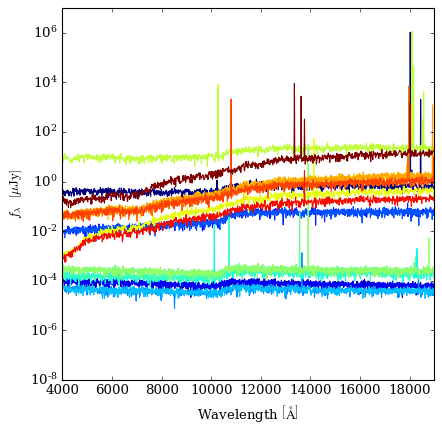

In [25]:
# Plot SEDs of first N galaxies
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
N = 20
carr = colour_array(N,cmap='jet')
for i in range(N):
    ax.plot(SED.wavelength,SED.sed[i,:],c=carr[i])
    #ax.plot(SED.wavelength,SED.continuum[i,:],c=carr[i]) 
    #ax.plot(SED.wavelength,SED.emissionLines[i,:],c=carr[i]) 
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(SED.wavelength.min(),SED.wavelength.max())
ax.set_ylim(bottom=1.0e-8)
show()

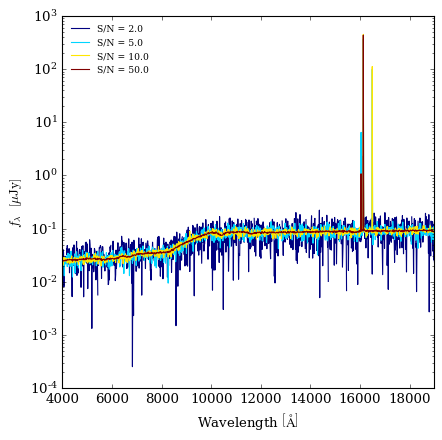

In [26]:
# EXAMPLE 2: Make plot showing different S/N ratios
z = 1.4
zStr = GH5.getRedshiftString(z)
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
snRatios = "2.0 5.0 10.0 50.0".split()
carr = colour_array(len(snRatios),cmap='jet')
for i,snr in enumerate(snRatios):        
    name = "totalSED:observed:Gaussian_VelocityApprox:snr"+snr+":"+zStr
    SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')
    ax.plot(SED.wavelength,SED.sed[12,:],c=carr[i],label="S/N = "+snr)
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(SED.wavelength.min(),SED.wavelength.max())
Legend(ax,loc=0)
show()
    

In [35]:
# Other galaxy properties can be extracted using the GalacticusHDF5 class. For example:
z = 1.47
properties = GH5.availableDatasets(z)
print(properties[:5]) # print first 5

['angularWeight', 'basicMass', 'basicTimeLastIsolated', 'blackHoleCount', 'blackHoleMass']


In [28]:
# Let's, for example, extract the lightcone redshifts of the galaxies from the output nearest to snapshot redshift 1.47.
import fnmatch
# Print all lightcone properties
print fnmatch.filter(properties,"lightcone*")

['lightconePositionX', 'lightconePositionY', 'lightconePositionZ', 'lightconeRedshift', 'lightconeVelocityX', 'lightconeVelocityY', 'lightconeVelocityZ']


In [29]:
# The lightcone redshift is stored as 'lightconeRedshift'. Read lightcone redshifts into numyp array.
z = 1.4
galaxies = GH5.readGalaxies(z,props=["lightconeRedshift"])
print galaxies["lightconeRedshift"]

[ 1.48608269  1.49035311  1.47004136  1.47386963  1.46996534  1.47380196
  1.4699883   1.4738705   1.46254863  1.46627373  1.45561775  1.45916284
  1.44866056  1.45199248  1.44194083  1.44514655  1.46258345  1.46626938
  1.42982781  1.43267295  1.42398882  1.42667309  1.49533117  1.47010573
  1.47396328  1.49434648  1.49544209  1.47940921  1.48367778  1.49662526
  1.48813742  1.49209793  1.47219761  1.47574599  1.46444086  1.46779334
  1.45759117  1.46073477  1.43761577  1.44029857  1.49635038  1.4963212
  1.46421259  1.46771712  1.47963914  1.48340015  1.49445171  1.47749457
  1.48157789  1.47745326  1.48155381  1.42401874  1.42657898  1.41358011
  1.49435197  1.47025993  1.47398453  1.4703976   1.47415152  1.4245378
  1.42704499  1.46244356  1.46599843  1.49442911  1.47139248  1.47542211
  1.47122178  1.4752143   1.49582873  1.49580675  1.49600876  1.4872084
  1.49183746  1.47156609  1.4757327   1.47145414  1.47557824  1.47149411
  1.47567754  1.46392036  1.46790899  1.41996446  1.46

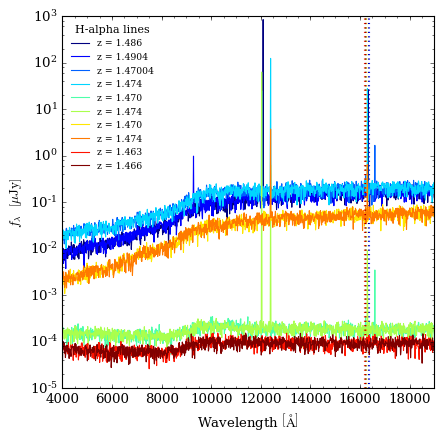

In [30]:
# EXAMPLE 3.1: Make plot showing SEDs for random sample of galaxies at different redshifts 
#              (using single snapshot directory)
z = 1.4
zStr = GH5.getRedshiftString(z)
redshifts = GH5.readGalaxies(z,props=["lightconeRedshift"])["lightconeRedshift"]
name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')

galaxyIndices = np.arange(len(redshifts))
np.random.shuffle(galaxyIndices)

halpha = GalSED.EmissionLines.EmissionLines.getWavelength("balmerAlpha6563")
##print halpha
#halpha = 6563.0

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
N = 10
carr = colour_array(N,cmap='jet')
for i in range(N):
    z = redshifts[i]
    line, = ax.plot(SED.wavelength,SED.sed[i,:],c=carr[i],label="z = "+sigfig(z,4))
    ax.axvline(halpha*(1.0+z),c=line.get_color(),ls=':')
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(SED.wavelength.min(),SED.wavelength.max())
minor_ticks(ax.xaxis)
Legend(ax,loc=0,title="H-alpha lines")
show()

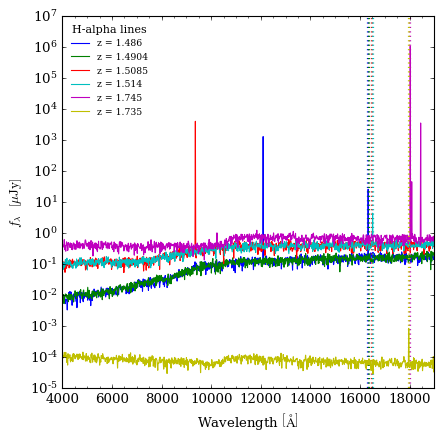

In [34]:
# EXAMPLE 3.2: Make plot showing SEDs for random sample of galaxies at different redshifts 
#              (using different snapshot directories)

halpha = GalSED.EmissionLines.EmissionLines.getWavelength("balmerAlpha6563")

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')

redshifts = [1.4,1.6,1.8]
for z in redshifts:
    zStr = GH5.getRedshiftString(z)
    redshifts = GH5.readGalaxies(z,props=["lightconeRedshift"])["lightconeRedshift"]
    name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
    SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')

    galaxyIndices = np.arange(len(redshifts))
    np.random.shuffle(galaxyIndices)    
    N = 2
    for i in range(N):
        iz = redshifts[i]
        line, = ax.plot(SED.wavelength,SED.sed[i,:],label="z = "+sigfig(iz,4))
        ax.axvline(halpha*(1.0+iz),c=line.get_color(),ls=':',lw=2.0)
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(SED.wavelength.min(),SED.wavelength.max())
minor_ticks(ax.xaxis)
Legend(ax,loc=0,title="H-alpha lines")
show()

In [17]:
# Now find the stellar masses.
print fnmatch.filter(properties,"*MassStellar")

['diskMassStellar', 'spheroidMassStellar']


In [18]:
# Stellar masses for the disk and bulge are stored separately. If the stellar mass for the total galaxy has been
# calculated it we will see a dataset "totalMassStellar". It looks like that the total stellar mass has not yet
# been computed, so we will have the compute it using the separate components.
galaxies = GH5.readGalaxies(z,props=["*MassStellar"])
# We can use wildcards to extract multiple properties
print galaxies.dtype.names
stellarMass = galaxies["diskMassStellar"] + galaxies["spheroidMassStellar"]
print stellarMass
# Note that some 'galaxies' have zero stellar mass. These entries in fact correspond to empty dark matter halos and
# so could be masked out.
mask = stellarMass > 0.0

('diskMassStellar', 'spheroidMassStellar')
[  3.36933849e+08   3.96859117e+04   3.96859117e+04   6.22191559e+07
   6.22191559e+07   3.02625614e+04   3.02625614e+04   2.29012313e+05
   2.29012313e+05   2.35699845e+05   2.35699845e+05   2.99471333e+10
   1.00493289e+09   4.41747608e+09   4.41747608e+09   2.47887632e+09
   2.47887632e+09   4.37443053e+08   0.00000000e+00   4.92882607e+10
   9.98925136e+09   1.47862192e+05   1.47862192e+05   1.89923124e+08
   6.22623037e+09   1.43822631e+09   2.54171901e+09   1.43225466e+09
   5.80277452e+08   1.88409457e+08   1.21110114e+04   1.21110114e+04
   5.34773871e+04   3.16769484e+08   3.16769484e+08   7.23514843e+08
   9.48204735e+09   9.48159409e+08   1.13861532e+09   5.91893048e+04
   2.88062382e+09   1.22548187e+05   5.08762289e+03   4.22042496e+08
   1.72670989e+08   3.38719655e+08   1.80423916e+05   1.80423916e+05
   6.84260131e+09   3.18918586e+05   1.63305165e+10   1.27028403e+04
   1.27028403e+04   8.51524706e+07   1.33021036e+10   2.1336